In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style()

In [6]:
x = np.array([[2],[1]])
x = x.reshape((-1,))
x

array([2, 1])

In [7]:
from torchvision.datasets import mnist
train_set = mnist.MNIST("./data", train=True, download=True)
test_set = mnist.MNIST("./data", train=False, download=True)


100.1%

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


113.5%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


100.4%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


180.4%..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [15]:
a_data, a_label = train_set[0]
print(type(a_data))
print(type(a_label))
a_data

<class 'PIL.Image.Image'>
<class 'int'>


In [17]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

(28, 28)


In [2]:
from torchvision.datasets import mnist
def data_tf(x):
    x = np.array(x, dtype="float32")/255
    x = (x-0.5)/0.5
    x = x.reshape((-1))
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=False) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=False)

In [3]:
from torch.utils.data import DataLoader
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=64, shuffle=False)
a, a_label = next(iter(train_data))
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [14]:
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100,10)
)
net = net.cuda()
net

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 1e-1)

losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im).cuda()
        label = Variable(label).cuda()
        
        out = net(im)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct/im.shape[0]
        train_acc += acc
        
    losses.append(train_loss/len(train_data))
    acces.append(train_acc/len(train_data))
    
    eval_loss = 0
    eval_acc = 0
    net.eval()
    for im, label in test_data:
        im = Variable(im).cuda()
        label = Variable(label).cuda()
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'.format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.513427, Train Acc: 0.829991, Eval Loss: 0.361605, Eval Acc: 0.883360
epoch: 1, Train Loss: 0.169333, Train Acc: 0.948428, Eval Loss: 0.133926, Eval Acc: 0.956907
epoch: 2, Train Loss: 0.115192, Train Acc: 0.963819, Eval Loss: 0.293057, Eval Acc: 0.900179
epoch: 3, Train Loss: 0.094927, Train Acc: 0.971415, Eval Loss: 0.168092, Eval Acc: 0.947850
epoch: 4, Train Loss: 0.076203, Train Acc: 0.975963, Eval Loss: 0.149705, Eval Acc: 0.953324
epoch: 5, Train Loss: 0.065634, Train Acc: 0.978911, Eval Loss: 0.094575, Eval Acc: 0.972134
epoch: 6, Train Loss: 0.052151, Train Acc: 0.983376, Eval Loss: 0.083150, Eval Acc: 0.973428
epoch: 7, Train Loss: 0.044521, Train Acc: 0.985541, Eval Loss: 0.097120, Eval Acc: 0.969248
epoch: 8, Train Loss: 0.039152, Train Acc: 0.987473, Eval Loss: 0.071586, Eval Acc: 0.977707
epoch: 9, Train Loss: 0.035881, Train Acc: 0.988390, Eval Loss: 0.120737, Eval Acc: 0.964570
epoch: 10, Train Loss: 0.029310, Train Acc: 0.990388, Eval Loss: 0.072

In [7]:
print(torch.tensor([[1,2],[3,4]]).max(1))

torch.return_types.max(
values=tensor([2, 4]),
indices=tensor([1, 1]))


Text(0.5, 1.0, 'test loss')

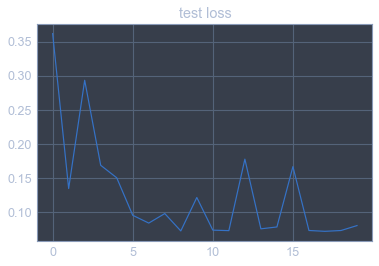

In [17]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')